[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/024_mlp_clasificacion/mlp_clasificacion.ipynb)

# El Perceptrón Multicapa - Clasificación

## El Perceptrón Multicapa

En el [post](https://sensioai.com/blog/023_mlp_backprop) anterior hemos introducido el modelo de `Perceptrón Multicapa`, o MLP, la arquitectura de red neuronal más básica basada en el [Perceptrón](https://sensioai.com/blog/012_perceptron1). Hemos visto cómo calcular la salida de un MLP de dos capas a partir de unas entradas y cómo encontrar los pesos óptimos para una tarea de regresión. En este post vamos a mejorar la implementación de nuestro MLP de dos capas para que sea capaz también de llevar a cabo tareas de clasificación.

![](https://www.researchgate.net/profile/Mohamed_Zahran6/publication/303875065/figure/fig4/AS:371118507610123@1465492955561/A-hypothetical-example-of-Multilayer-Perceptron-Network.png)

## Implementación

La mayoría del código que utilizaremos fue desarrollado para el `Perceptrón` y lo puedes encontrar en este [post](https://sensioai.com/blog/018_perceptron_final). Lo único que cambiaremos es la lógica del modelo, el resto de funcionalidad (funciones de pérdida, funciones de activación, etc, siguen siendo exactamente igual).

### Funciones de activación

Para la capa oculta de nuestro MLP utilizaremos una función de activación de tipo `relu`, de la cual necesitaremos su derivada.

In [55]:
def relu(x):
  return np.maximum(0, x)

def reluPrime(x):
  return x > 0

En cuanto a las funciones de activación que utilizaremos a la salida del MLP, éstas son las que hemos introducido en posts anteriores:

- Lineal: usada para regresión (junto a la función de pérdida MSE).
- Sigmoid: usada para clasificación binaria (junto a la función de pérdida BCE).
- Softmax: usada para clasificación multiclase (junto a la función de pérdida crossentropy, CE).

In [56]:
def linear(x):
    return x

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=-1,keepdims=True)

### Funciones de pérdida

Como acabamos de comentar en la sección anterior, estas son las funciones de pérdida que hemos visto hasta ahora para las diferentes tareas.

In [57]:
# Mean Square Error -> usada para regresión (con activación lineal)
def mse(y, y_hat):
    return np.mean((y_hat - y.reshape(y_hat.shape))**2)

# Binary Cross Entropy -> usada para clasificación binaria (con sigmoid)
def bce(y, y_hat):
    return - np.mean(y.reshape(y_hat.shape)*np.log(y_hat) - (1 - y.reshape(y_hat.shape))*np.log(1 - y_hat))

# Cross Entropy (aplica softmax + cross entropy de manera estable) -> usada para clasificación multiclase
def crossentropy(y, y_hat):
    logits = y_hat[np.arange(len(y_hat)),y]
    entropy = - logits + np.log(np.sum(np.exp(y_hat),axis=-1))
    return entropy.mean()

Y sus derivadas

In [58]:
def grad_mse(y, y_hat):
    return y_hat - y.reshape(y_hat.shape)

def grad_bce(y, y_hat):
    return y_hat - y.reshape(y_hat.shape)

def grad_crossentropy(y, y_hat):
    answers = np.zeros_like(y_hat)
    answers[np.arange(len(y_hat)),y] = 1    
    return (- answers + softmax(y_hat)) / y_hat.shape[0]

### Implementación MLP

Ahora que ya tenemos definidas las diferentes funciones de activación y de pérdida que necesitamos, vamos a implementar nuestro MLP de dos capas capaz de llevar a cabo tanto tareas de regresión como de clasificación. Del mismo modo que ya hicimos con el `Perceptrón`, definiremos una clase base que servirá para la implementación de las clases particulares para cada caso.

In [59]:
# clase base MLP 

class MLP():
  def __init__(self, D_in, H, D_out, loss, grad_loss, activation):
    # pesos de la capa 1
    self.w1, self.b1 = np.random.normal(loc=0.0,
                                  scale=np.sqrt(2/(D_in+H)),
                                  size=(D_in, H)), np.zeros(H)
    # pesos de la capa 2
    self.w2, self.b2 = np.random.normal(loc=0.0,
                                  scale=np.sqrt(2/(H+D_out)),
                                  size=(H, D_out)), np.zeros(D_out)
    self.ws = []
    # función de pérdida y derivada
    self.loss = loss
    self.grad_loss = grad_loss
    # función de activación
    self.activation = activation

  def __call__(self, x):
    # salida de la capa 1
    self.h_pre = np.dot(x, self.w1) + self.b1
    self.h = relu(self.h_pre)
    # salida del MLP
    y_hat = np.dot(self.h, self.w2) + self.b2 
    return self.activation(y_hat)
    
  def fit(self, X, Y, epochs = 100, lr = 0.001, batch_size=None, verbose=True, log_each=1):
    batch_size = len(X) if batch_size == None else batch_size
    batches = len(X) // batch_size
    l = []
    for e in range(1,epochs+1):     
        # Mini-Batch Gradient Descent
        _l = []
        for b in range(batches):
            # batch de datos
            x = X[b*batch_size:(b+1)*batch_size]
            y = Y[b*batch_size:(b+1)*batch_size] 
            # salida del perceptrón
            y_pred = self(x) 
            # función de pérdida
            loss = self.loss(y, y_pred)
            _l.append(loss)        
            # Backprop 
            dldy = self.grad_loss(y, y_pred) 
            grad_w2 = np.dot(self.h.T, dldy)
            grad_b2 = dldy.mean(axis=0)
            dldh = np.dot(dldy, self.w2.T)*reluPrime(self.h_pre)      
            grad_w1 = np.dot(x.T, dldh)
            grad_b1 = dldh.mean(axis=0)
            # Update (GD)
            self.w1 = self.w1 - lr * grad_w1
            self.b1 = self.b1 - lr * grad_b1
            self.w2 = self.w2 - lr * grad_w2
            self.b2 = self.b2 - lr * grad_b2
        l.append(np.mean(_l))
        # guardamos pesos intermedios para visualización
        self.ws.append((
            self.w1.copy(),
            self.b1.copy(),
            self.w2.copy(),
            self.b2.copy()
        ))
        if verbose and not e % log_each:
            print(f'Epoch: {e}/{epochs}, Loss: {np.mean(l):.5f}')

  def predict(self, ws, x):
    w1, b1, w2, b2 = ws
    h = relu(np.dot(x, w1) + b1)
    y_hat = np.dot(h, w2) + b2
    return self.activation(y_hat)

In [60]:
# MLP para regresión
class MLPRegression(MLP):
    def __init__(self, D_in, H, D_out):
        super().__init__(D_in, H, D_out, mse, grad_mse, linear)

# MLP para clasificación binaria
class MLPBinaryClassification(MLP):
    def __init__(self, D_in, H, D_out):
        super().__init__(D_in, H, D_out, bce, grad_bce, sigmoid)

# MLP para clasificación multiclase
class MLPClassification(MLP):
    def __init__(self, D_in, H, D_out):
        super().__init__(D_in, H, D_out, crossentropy, grad_crossentropy, linear)

Vamos a probar ahora nuestra implementación para diferentes ejemplos.

## Regresión

En primer lugar, vamos a replicar los resultados obtenidos en el post anterior para verificar que nuestro modelo de MLP sigue funcionando bien.

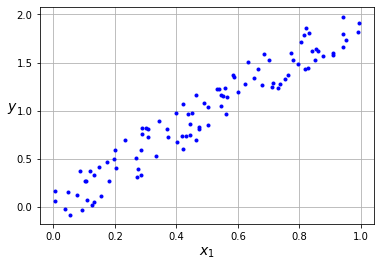

In [61]:
import numpy as np
import matplotlib.pyplot as plt

x = np.random.rand(100)
X = x.reshape(-1, 1)
y = 2*x + (np.random.rand(100)-0.5)*0.5

plt.plot(x, y, "b.")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=14)
plt.grid(True)
plt.show()

In [62]:
model = MLPRegression(D_in=1, H=3, D_out=1)
epochs, lr = 50, 0.01
model.fit(x.reshape(len(x),1), y, epochs, lr, log_each=10)

Epoch: 10/50, Loss: 1.15845
Epoch: 20/50, Loss: 1.07995
Epoch: 30/50, Loss: 1.01098
Epoch: 40/50, Loss: 0.95024
Epoch: 50/50, Loss: 0.89661


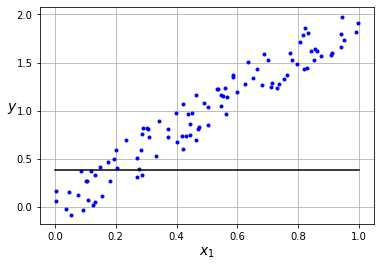

In [63]:
x_new = np.linspace(0, 1, 100)
x_new = x_new.reshape(len(x_new),1)
y_pred = model(x_new)
    
plt.plot(x, y, "b.")
plt.plot(x_new, y_pred, "-k")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=14)
plt.grid(True)
plt.show()

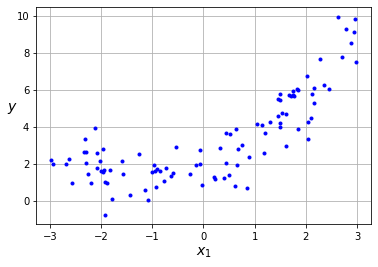

In [64]:
m = 100
x = 6 * np.random.rand(m, 1) - 3
y = 0.5 * x**2 + x + 2 + np.random.randn(m, 1)

plt.plot(x, y, "b.")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=14)
plt.grid(True)
plt.show()

In [65]:
model = MLPRegression(D_in=1, H=6, D_out=1)
epochs, lr = 50, 0.01
model.fit(x.reshape(len(x),1), y, epochs, lr, batch_size=1, log_each=10)

Epoch: 10/50, Loss: 1.34682
Epoch: 20/50, Loss: 1.19726
Epoch: 30/50, Loss: 1.14765
Epoch: 40/50, Loss: 1.12311
Epoch: 50/50, Loss: 1.10772


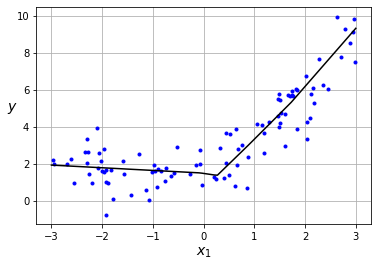

In [66]:
x_new = np.linspace(-3, 3, 100)
x_new = x_new.reshape(len(x_new),1)
y_pred = model(x_new)
    
plt.plot(x, y, "b.")
plt.plot(x_new, y_pred, "-k")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=14)
plt.grid(True)
plt.show()

Como puedes observar nuestro MLP es capaz de ajustarse a datos que no sigan una distribución lineal. Ésta es la principal limitación del `Perceptrón`, es un modelo muy simple, y el MLP es capaz de solventar este problema (siempre y cuando usemos funciones de activación no lineales en la capa oculta. ¿Sabes por qué? Puedes encontrar la respuesta en el [post](https://sensioai.com/blog/023_mlp_backprop) anterior).

## Clasificación Binaria

Ahora vamos a aplicar nuestro MLP al problema de clasificación binaria. Para ellos vamos a utilizar el dataset *Iris*, que ya conocemos de los posts anteriores de clasificación con el `Perceptrón`.

In [67]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = iris.target

X.shape, y.shape

((150, 2), (150,))

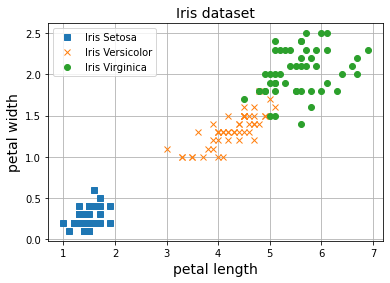

In [68]:
plt.plot(X[y==0, 0], X[y==0, 1], 's', label="Iris Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], 'x', label="Iris Versicolor")
plt.plot(X[y==2, 0], X[y==2, 1], 'o', label="Iris Virginica")
plt.grid()
plt.legend()
plt.xlabel('petal length', fontsize=14)
plt.ylabel('petal width', fontsize=14)
plt.title("Iris dataset", fontsize=14)
plt.show()

Este dataset contiene información sobre flores y el objetivo es clasificar en tres clases distintas. En esta sección vamos a intentar separar simplemente una de las clases del resto (clasificación binaria).

In [69]:
y = (iris.target == 0).astype(np.int)

<ipython-input-69-568fdf940d76>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris.target == 0).astype(np.int)


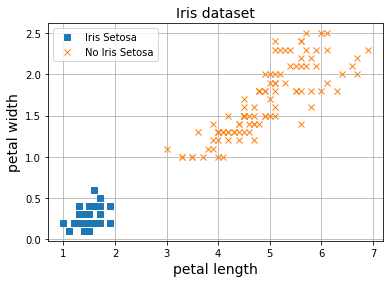

In [70]:
plt.plot(X[y==1, 0], X[y==1, 1], 's', label="Iris Setosa")
plt.plot(X[y==0, 0], X[y==0, 1], 'x', label="No Iris Setosa")
plt.grid()
plt.legend()
plt.xlabel('petal length', fontsize=14)
plt.ylabel('petal width', fontsize=14)
plt.title("Iris dataset", fontsize=14)
plt.show()

In [71]:
model = MLPBinaryClassification(D_in=2, H=3, D_out=1)
epochs, lr = 50, 0.01

# normalización datos
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
X_norm = (X - X_mean) / X_std

model.fit(X_norm, y, epochs, lr, batch_size=1, log_each=10)

Epoch: 10/50, Loss: -0.10191
Epoch: 20/50, Loss: -0.05635
Epoch: 30/50, Loss: -0.03903
Epoch: 40/50, Loss: -0.02991
Epoch: 50/50, Loss: -0.02429


In [72]:
from matplotlib import animation, rc
from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(['#9898ff', '#fafab0'])
rc('animation', html='html5')

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)
def plot(i, axes = [0.5, 5, 0, 2], label="Iris Setosa"):
    ax.clear()
    w = model.ws[i]
    tit = ax.set_title(f"Epoch {i+1}", fontsize=14)
    x0, x1 = np.meshgrid(
            np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
            np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
        )
    X_new = np.c_[x0.ravel(), x1.ravel()]
    X_new = (X_new - X_mean) / X_std 
    y_predict = model.predict(w, X_new)
    zz = y_predict.reshape(x0.shape)
    ax.plot(X[y==0, 0], X[y==0, 1], "bs", label=f"No {label}")
    ax.plot(X[y==1, 0], X[y==1, 1], "yo", label=label)
    ax.contourf(x0, x1, zz, cmap=custom_cmap)
    ax.set_xlabel("Petal length", fontsize=14)
    ax.set_ylabel("Petal width", fontsize=14)
    ax.legend(loc="lower right", fontsize=14)
    ax.axis(axes)
    return ax

anim = animation.FuncAnimation(fig, plot, frames=epochs, interval=200)
plt.close()
anim

Nuestro MLP es capaz de separar las clases sin problema. Si recuerdas, en el caso del `Perceptrón`, el modelo no era capaz de separar las flores de tipo *Iris Versicolor* del resto, ya que esta clase no es linealmente separable.

<ipython-input-73-9df572ef30ca>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris.target == 1).astype(np.int)


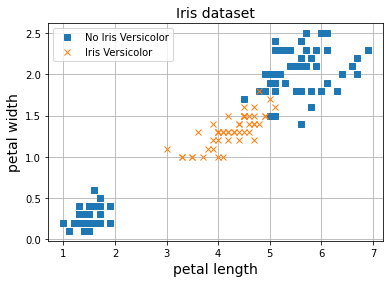

In [73]:
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 1).astype(np.int)

X_mean, X_std = X.mean(axis=0), X.std(axis=0)
X_norm = (X - X_mean) / X_std

plt.plot(X[y==0, 0], X[y==0, 1], 's', label="No Iris Versicolor")
plt.plot(X[y==1, 0], X[y==1, 1], 'x', label="Iris Versicolor")
plt.grid()
plt.legend()
plt.xlabel('petal length', fontsize=14)
plt.ylabel('petal width', fontsize=14)
plt.title("Iris dataset", fontsize=14)
plt.show()

Sin embargo, nuestro nuevo modelo, el MLP, es capaz de solventar este problema.

In [74]:
model = MLPBinaryClassification(D_in=2, H=10, D_out=1)
epochs, lr = 50, 0.1
model.fit(X_norm, y, epochs, lr, batch_size=1, log_each=10)

Epoch: 10/50, Loss: 0.01859
Epoch: 20/50, Loss: 0.00663
Epoch: 30/50, Loss: 0.00158
Epoch: 40/50, Loss: -0.00129
Epoch: 50/50, Loss: -0.00315


In [75]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)

def plot(i, axes = [0.5, 7, 0, 2.8], label="Iris Versicolor"):
    ax.clear()
    w = model.ws[i]
    tit = ax.set_title(f"Epoch {i+1}", fontsize=14)
    x0, x1 = np.meshgrid(
            np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
            np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
        )
    X_new = np.c_[x0.ravel(), x1.ravel()]
    X_new = (X_new - X_mean) / X_std 
    y_predict = model.predict(w, X_new)
    zz = y_predict.reshape(x0.shape)
    ax.plot(X[y==0, 0], X[y==0, 1], "bs", label=f"No {label}")
    ax.plot(X[y==1, 0], X[y==1, 1], "yo", label=label)
    ax.contourf(x0, x1, zz, cmap=custom_cmap)
    ax.set_xlabel("Petal length", fontsize=14)
    ax.set_ylabel("Petal width", fontsize=14)
    ax.legend(loc="lower right", fontsize=14)
    ax.axis(axes)
    return ax

anim = animation.FuncAnimation(fig, plot, frames=epochs, interval=200)
plt.close()
anim

Como puedes observar, el MLP es capaz de resolver el problema del `Perceptrón`, y es que cuantas más capas y neuronas por capas usemos, mayor capacidad de representación tendrá el modelo (las redes neuronales más grandes a día de hoy tienen varios Billones de conexiones).

## Clasificación Multiclase

Por último vamos a ver cómo aplicar nuestro modelo para clasificación en multiples clases.

In [76]:
from google.colab import drive
import pandas as pd

In [77]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
data = pd.read_csv("/content/drive/MyDrive/Datasets/emnist-balanced-test.csv")
print(data)
data = np.array(data)
X = data[:,1:]
y = data[:,0]

       41  0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  ...  0.523  0.524  \
0      39  0    0    0    0    0    0    0    0    0  ...      0      0   
1       9  0    0    0    0    0    0    0    0    0  ...      0      0   
2      26  0    0    0    0    0    0    0    0    0  ...      0      0   
3      44  0    0    0    0    0    0    0    0    0  ...      0      0   
4      33  0    0    0    0    0    0    0    0    0  ...      0      0   
...    .. ..  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
18794  45  0    0    0    0    0    0    0    0    0  ...      0      0   
18795  15  0    0    0    0    0    0    0    0    0  ...      0      0   
18796   1  0    0    0    0    0    0    0    0    0  ...      0      0   
18797  26  0    0    0    0    0    0    0    0    0  ...      0      0   
18798  33  0    0    0    0    0    0    0    0    0  ...      0      0   

       0.525  0.526  0.527  0.528  0.529  0.530  0.531  0.532  
0          0      0      0      0  

In [92]:
model = MLPClassification(D_in=784, H=12, D_out=47)
epochs, lr = 200, 0.0005
model.fit(X, y, epochs, lr, batch_size=100, log_each=10)
XPrueba = X[4002:4003, :].copy()
y_predecir = model(XPrueba)
indice = np.argmax(y_predecir)
print("El número es clasificado como un", indice)

Epoch: 10/200, Loss: 3.97614
Epoch: 20/200, Loss: 3.91260
Epoch: 30/200, Loss: 3.89130
Epoch: 40/200, Loss: 3.88063
Epoch: 50/200, Loss: 3.87421
Epoch: 60/200, Loss: 3.86993
Epoch: 70/200, Loss: 3.86687
Epoch: 80/200, Loss: 3.86457
Epoch: 90/200, Loss: 3.86277
Epoch: 100/200, Loss: 3.86133
Epoch: 110/200, Loss: 3.86014
Epoch: 120/200, Loss: 3.85915
Epoch: 130/200, Loss: 3.85830
Epoch: 140/200, Loss: 3.85758
Epoch: 150/200, Loss: 3.85695
Epoch: 160/200, Loss: 3.85639
Epoch: 170/200, Loss: 3.85589
Epoch: 180/200, Loss: 3.85545
Epoch: 190/200, Loss: 3.85505
Epoch: 200/200, Loss: 3.85469
El número es clasificado como un 25


In [ ]:
"""from matplotlib.colors import ListedColormap
from matplotlib import animation, rc
rc('animation', html='html5')       
    
def animate(i, resolution=0.02):
    ax.clear()
    tit = ax.set_title(f"Epoch {i+1}", fontsize=14)
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    X_new = (np.array([xx1.ravel(), xx2.ravel()]).T - X_mean)/X_std
    w = model.ws[i]
    Z = model.predict(w, X_new)
    Z = np.argmax(softmax(Z), axis=1) 
    #print(Z)
    Z = Z.reshape(xx1.shape)
    ax.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())
    ax.set_xlabel('petal length', fontsize=14)
    ax.set_ylabel('petal width', fontsize=14)
    classes = ["Iris-Setosa", "Iris-Versicolor", "Iris-Virginica"]
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=classes[cl], 
                    edgecolor='black')
    ax.legend(loc='upper left', fontsize=14)
    return [tit]

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111, autoscale_on=False)
anim = animation.FuncAnimation(fig, animate, frames=epochs, interval=100, blit=True)
plt.close()
anim"""

De nuevo, nuestro MLP es capaz de separar las tres clases en el dataset. En posts anteriores hemos trabajado también con el dataset MNIST para clasificación de imágenes en diez clases distintas. ¿Te ves capaz de utilizar nuestro MLP para resolver ese problema?

## Resumen

En este post hemos visto como implementar un `Perceptrón Multicapa` en `Python` para tareas de regresión y clasificación. Como ya hicimos anteriormente para el caso del `Perceptrón` hemos validado nuestra implementación con el dataset de clasificación de flores *Iris*, tanto para clasificación binaria como multiclase. Sin embargo, nuestra implementación está muy limitada. ¿Qué pasa si queremos usar un MLP de más de dos capas?, ¿y si queremos usar una función de activación diferente a la `relu` en la capa oculta?, ¿podríamos utilizar un algoritmo de optimizaciñon diferente al `descenso por gradiente`? Para poder hacer todo esto necesitamos un `framework` más flexible, similar a lo que nos ofrecen `Pytorch` y `Tensorflow`. En el siguiente post desarrollaremos nuestro propio framework de MLP para que sea más flexible y que también nos servirá para entender cómo funcionan el resto de frameworks de `redes neuronales` por dentro.